# Foreign Exchange Forecasting using LSTMs

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pylab import rcParams
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import keras
from keras.layers import Dropout, Bidirectional, CuDNNLSTM, Dense, Activation, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

2023-06-05 19:46:34.336048: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-05 19:46:34.538392: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 19:46:35.678895: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Google Spreadsheet ID
SHEET_ID = '1JDNv_mArl-GPIpxuWS5GxgVEwvjXocS1MrXGc6TYs8M'
SHEET_NAME = 'USD/IDR'

# USD-IDR

## Data Overview
From Google Finance

In [3]:
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'
df = pd.read_csv(url, parse_dates=['Date'])
df.drop('Unnamed: 2', axis=1, inplace=True)
df = df.sort_values('Date')
df.head()

,Date,Close
0,01/01/2020 23:58:00,13689.23
366,01/01/2021 23:58:00,14024.13
731,01/01/2022 23:58:00,14242.00
1096,01/01/2023 23:58:00,15538.50
31,01/02/2020 23:58:00,13762.30


Text(0, 0.5, 'Close Price (IDR)')

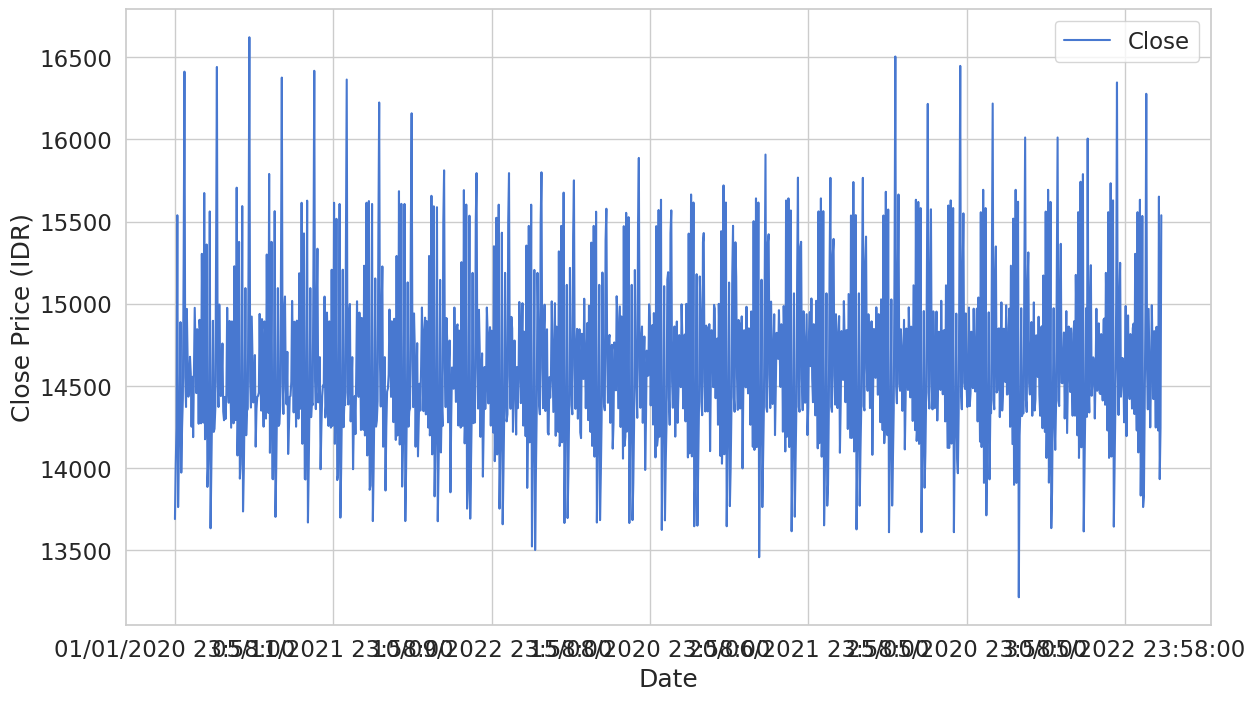

In [4]:
ax = df.plot(x='Date', y='Close')
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (IDR)")

## Data preprocessing

In [5]:
scaler = StandardScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close.shape

(1247, 1)

In [6]:
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

## Making sequences

In [7]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)

def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.90)

In [8]:
X_train.shape

(1032, 99, 1)

In [9]:
y_train.shape

(1032, 1)

## Building LSTM model

In [10]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()
model.add(Bidirectional(
  LSTM(WINDOW_SIZE, return_sequences=True),
  input_shape=(WINDOW_SIZE, X_train.shape[-1])
))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(
  LSTM((WINDOW_SIZE * 2), return_sequences=True)
))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(
  LSTM(WINDOW_SIZE, return_sequences=False)
))
model.add(Dense(units=1))
model.add(Activation('linear'))

2023-06-05 19:46:38.491882: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-05 19:46:38.695082: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-05 19:46:38.695316: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-05 19:46:38.698742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-05 19:46:38.698910: I tensorflow/compile

## Training

In [11]:
BATCH_SIZE = 64

model.compile(
    loss='mean_squared_error',
    metrics=['mae'],
    optimizer='adam',
)
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50


2023-06-05 19:46:43.192608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 19:46:43.194093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 19:46:43.195283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - ETA: 0s - loss: 0.9332 - mae: 0.7746

2023-06-05 19:46:57.004972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 19:46:57.006805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 19:46:57.007893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 15s 163ms/step - loss: 0.9332 - mae: 0.7746 - val_loss: 0.8636 - val_mae: 0.7607
Epoch 2/50
15/15 [==============================] - 1s 54ms/step - loss: 0.8132 - mae: 0.7116 - val_loss: 0.5647 - val_mae: 0.5617
Epoch 3/50
15/15 [==============================] - 1s 57ms/step - loss: 0.6746 - mae: 0.6396 - val_loss: 0.5638 - val_mae: 0.5752
Epoch 4/50
15/15 [==============================] - 1s 61ms/step - loss: 0.6532 - mae: 0.6447 - val_loss: 0.5266 - val_mae: 0.5532
Epoch 5/50
15/15 [==============================] - 1s 55ms/step - loss: 0.5651 - mae: 0.5950 - val_loss: 0.4483 - val_mae: 0.5267
Epoch 6/50
15/15 [==============================] - 1s 55ms/step - loss: 0.5664 - mae: 0.5941 - val_loss: 0.4421 - val_mae: 0.5280
Epoch 7/50
15/15 [==============================] - 1s 53ms/step - loss: 0.6030 - mae: 0.6162 - val_loss: 0.4689 - val_mae: 0.5572
Epoch 8/50
15/15 [==============================] - 1s 54ms/step - loss: 0.6029 - mae: 0.607

In [12]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 29ms/step - loss: 0.8235 - mae: 0.5655


[0.8234647512435913, 0.565533459186554]

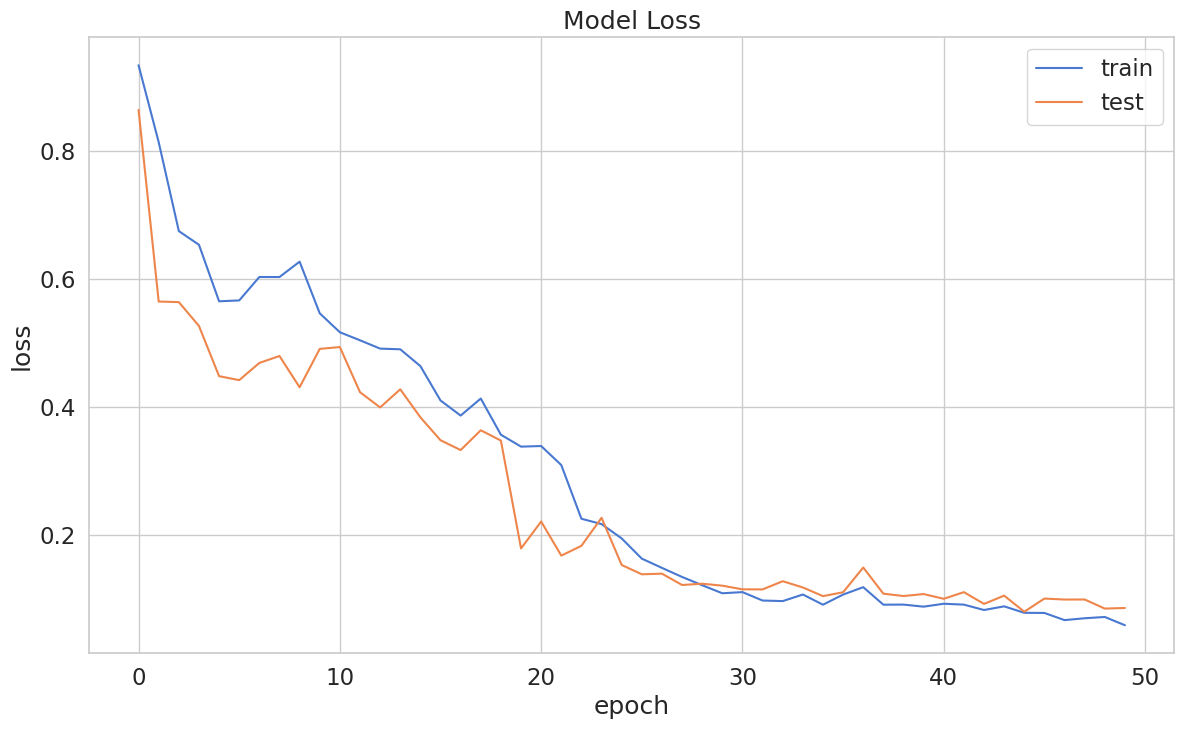

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

## Prediction

2023-06-05 19:47:42.277292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 19:47:42.279103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 19:47:42.280198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 33ms/step


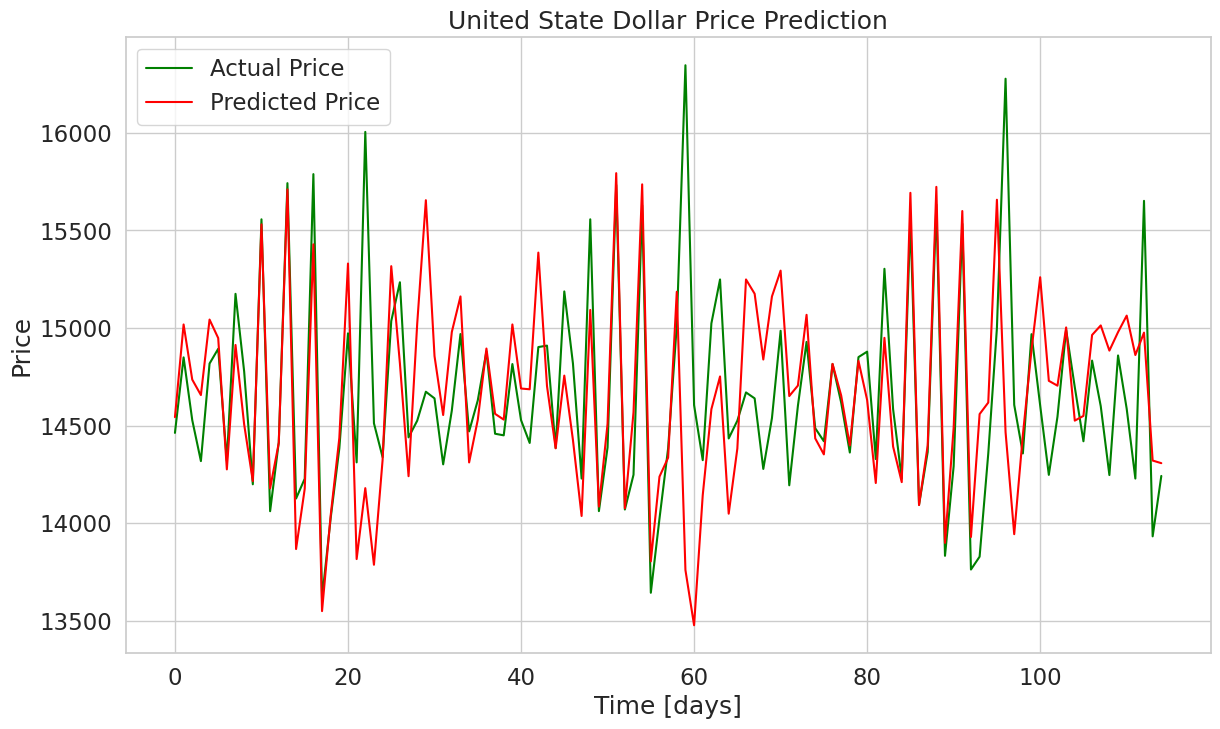

In [14]:
y_hat = model.predict(X_test)
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('United State Dollar Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

In [20]:
def matrices(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    print("Mean Squared Error for prediction :", mse)
    print("Mean Absolute Error for prediction :", mae)
    print("Root Mean Squared Error for prediction :", rmse)

matrices(y_test, y_hat)

Mean Squared Error for prediction : 0.823464834208835
Mean Absolute Error for prediction : 0.565533417135461
Root Mean Squared Error for prediction : 0.9074496317751388
